In [1]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Video
from IPython.display import HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Linear Models

### David Picard 
### École Nationale des Ponts et Chaussées
### david.picard@enpc.fr

# Linear Regression
## Scalar input, scalar output

- Input space: $x \in \mathbb{R}$
- Output space: $y \in \mathbb{R}$
- Linear model: $f(x) = ax$

$$ \min_{a} \mathbb{E}_x [ (y - ax)^2 ]$$

Training set $\mathcal{A} = \{(x_i, y_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i (y_i - ax_i)^2$$

This is the simplest case possible. You have a set of pairs of scalar values and want to know the best coefficient to transform one into the other. Now that it is framed as \emph{``minimizing the empirical risk''}, it called be called AI and sold at a higher price. You're welcome.

Closed form solution:
- vectorize: $\mathbf{x} = [x_i]$, $\mathbf{y} = [y_i]$
$$ \min_a \frac{1}{n} \| \mathbf{y} - a\mathbf{x} \|^2 $$
- Stationary condition
$$ \frac{\partial}{\partial a}  \frac{1}{n}\| \mathbf{y} - a\mathbf{x} \|^2 = 0 = 2a \|\mathbf{x}\|^2 - 2 \langle \mathbf{y}, \mathbf{x} \rangle$$
$$ a = \frac{\mathbf{y}^\top\mathbf{x}}{\|\mathbf{x}\|^2}$$

## Linear regression - Vector input, scalar output

- Input space: $\mathbf{x} \in \mathbb{R}^d$
- Output space: $y \in \mathbb{R}$
- Linear model: $f(x) = \mathbf{a}^\top\mathbf{x}$

$$ \min_{\mathbf{a}} \mathbb{E}_x [ (y - \mathbf{a}^\top\mathbf{x})^2 ]$$


Training set $\mathcal{A} = \{(\mathbf{x}_i, y_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i (y_i - \mathbf{a}^\top\mathbf{x}_i)^2$$


The next version is slightly more practical, as we now want to predict a scalar value from a vector.

Closed form solution
- Matrix form: $\mathbf{X} = [\mathbf{x}_i]$, $\mathbf{y} = [y_i]$

$$ \min_\mathbf{a} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} \|^2$$

- Stationary condition

$$\frac{\partial}{\partial \mathbf{a}} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} \|^2 = 0 = -2\mathbf{X}^\top\mathbf{y} + 2\mathbf{XX}^\top\mathbf{a} $$

$$ \mathbf{a} = (\mathbf{XX}^\top)^{-1} \mathbf{X}^\top\mathbf{y} $$

Pseudo-inverse

Notice that it is required that $\mathbf{XX}^\top$ be invertible. For this, it is required that $\mathbf{X}$ has rank $d$, and thus if we have less training samples than dimension, we cannot use the pseu-do inverse technique. At least, not in this fashion. Instead, we have to resort to the dual approach using the Gram matrix.

## Vector input, bis

- SVD: $\mathbf{X} = \mathbf{USV}^\top$

$$ \mathbf{y} = \mathbf{VSU}^\top\mathbf{a} $$
$$ \mathbf{a} = \mathbf{US}^{-1}\mathbf{V}^\top\mathbf{y}$$

Easy solution by projecting into the eigen space of $\mathbf{X}$, $\mathbf{a}$ is in the eigenspace of $\mathbf{X}$

## Karhunen-Loève theorem

Let $\mathbf{x}$ be a stochastic process with covariance matrix $\sum_\mathbf{x}$ then

$$ \mathbf{x}_i = \sum_k^p z_{k,i}\mathbf{e}_k $$

with $\mathbf{e_k}$ the eigenvectors of $\sum_\mathbf{x}$.

- Samples $\mathbf{x}_i$ exist in the space spaned by the eigenvectors of the covariance matrix (hence PCA)
- if $span(\mathbf{x}) < d$, some dimensions are useless (noisy)
- Strong influence on the pseudo-inverse solution ($\mathbf{S}^{-1}$) $\Rightarrow$ remove directions with small eigenvalues

We mention here the Karhunen-Loève theorem to prepare for future results known a representer theorems. The key idea is that since samples exist in a space that is defined by the eigenvectors of their covariance matrix, it is intuitive that only these eigenvector play a role in finding the solution to our regression problem. In essence, why should a direction that never happens in the data matter for the problem? The answer is it shouldn't and this is why the eigenspace of the data appears in the solution.

In [2]:
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key)
x = jax.random.uniform(skey, (50, 1))
X = jnp.concatenate((x, -5*x), axis=1)
a = jnp.array([2, 0])
y = jnp.matmul(X, a)

U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S))
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)
print('a_hat: {} a: {}'.format(a_hat, a))

eigenvalues: [2.0413006e+01 3.0459864e-07]
a_hat: [-2.8013153  -0.96026266] a: [2 0]


## Linear regression, bias case

Adding a constant to the model is equivalent to the vector case



$$ \min_{\mathbf{a}, b} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} - \mathbf{1}^\top b \|^2$$

- concatenate $b$ to $\mathbf{a}$ and $1$ to $\mathbf{X}$

$$ \min_{\mathbf{a}, b} \frac{1}{n} \|\mathbf{y} - [\mathbf{X}; \mathbf{1}]^\top[\mathbf{a}; b] \|^2$$

## Linear Regression, Vector input, vector output


- Input space: $\mathbf{x} \in \mathbb{R}^d$
- Output space: $\mathbf{y} \in \mathbb{R}^p$
- Linear model: $f(x) = \mathbf{A}^\top\mathbf{x}$

$$ \min_{\mathbf{a}} \mathbb{E}_x [ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 ]$$


Training set $\mathcal{A} = \{(\mathbf{x}_i, \mathbf{y}_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i \|\mathbf{y}_i - \mathbf{A}^\top\mathbf{x}_i\|^2$$

Equivalent to $p$ scalar output cases stacked together

This is ultimately the real practical application of linear regression: predict several values altogether. However, it is rather unsatisfying since it turns out to be equivalent to performing independent scalar regression in parallel. This is because we never put any constraints on the columns of $\mathbf{A}$ to be correlated.

## Let's try with MNIST

Regress 0 and 1

0


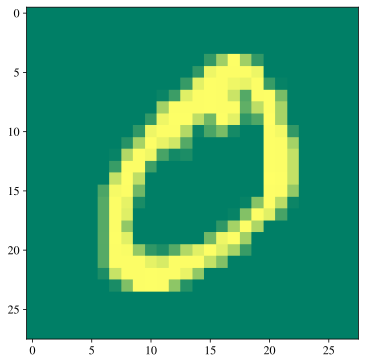

In [3]:
data = np.load('mnist.npz')
X = data['X_train_bin']
y = data['y_train_bin']
plt.imshow(X[0,:].reshape(28,28))
print(y[0])

eigenvalues: [36.45615   17.209862  12.030047  11.947479   9.36883    7.8752723
  6.7997932  6.3316774  5.729243   5.4004116  5.1866603  4.988159
  4.8420706  4.1217637  3.9173453  3.5896347  3.2801106  3.1127822
  3.0160408  2.7964358  2.6677098  2.543037   2.2888196  2.1948047
  2.14488    1.8337901  1.0252038]


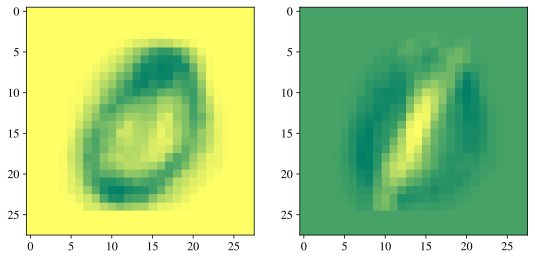

In [4]:
U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S))
plt.subplot(1,2,1)
plt.imshow(U[:,0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(U[:,1].reshape((28,28)))


If we interpret our predictor as an image, positive pixels tend to push the prediction towards class 1, whereas negative pixels tend to push the prediction toward class 0. Let us display the images of pixels of the same sign.

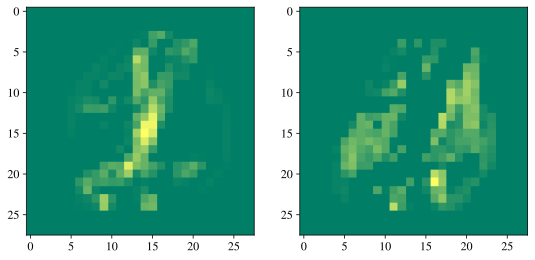

In [5]:
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)

plt.subplot(1,2,1)
plt.imshow(jnp.maximum(a_hat, 0).reshape((28, 28)))
plt.subplot(1,2,2)
plt.imshow(jnp.maximum(-a_hat, 0).reshape((28, 28)))

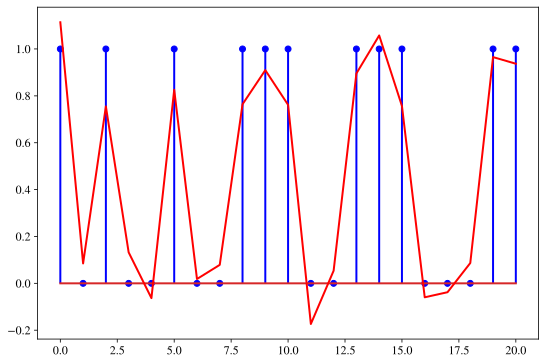

In [6]:
X_val = data['X_val_bin']
y_val = data['y_val_bin']
y_hat = jnp.matmul(X_val, a_hat)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

This is actually not bad! Remember that this is on a validation set, and fixing a threshold at $0.5$ we can even reach 100% accuracy on this very small validation set.

## MNIST, regress 0-9

eigenvalues: [61.84758  22.601597 19.816174 18.98699  17.21556  15.531815 14.318835
 13.584824 12.348789 11.739741]


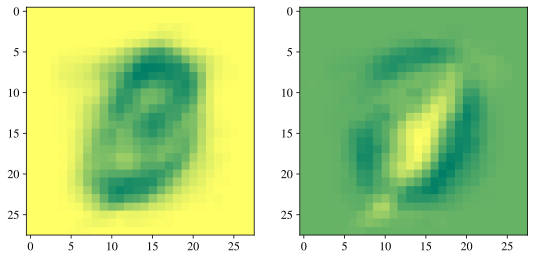

In [7]:
X = data['X_train']
y = data['y_train']

U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S[0:10]))
plt.subplot(1,2,1)
plt.imshow(U[:,0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(U[:,1].reshape((28,28)))

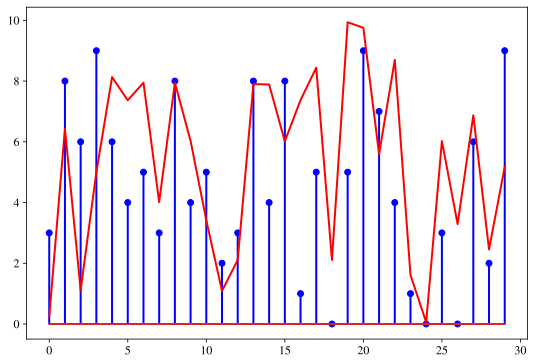

In [8]:
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)

X_val = data['X_val'][0:30,...]
y_val = data['y_val'][0:30]
y_hat = jnp.matmul(X_val, a_hat)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

Output space not adapted (artificial topology)

Here we are doing much worse. Because we are predicting the classes as a real value between 0 and 9, we have a success if and only if we are predicting within $0.5$ of the target value. The annoying aspect with theis approach is that to us, as an optical character recognition task, a failure is a failure, no matter what was the digit that was predicted. That the function predicts a 3 or an 8 instead of a 2 is exactly the same because it is the wrong character, but the regression loss considers those errors to be different. It values predicting a 3 for a 2 better than predicting an 8 because we introduced an arbitrary sense of distance between the classes.

This could be aleviated by making sure all classes are equidistant with respect to the norm that is used for the regression.

## MNIST regress 0-9 as one-hot
- Exercise: train a linear regression for each class (one versus all)

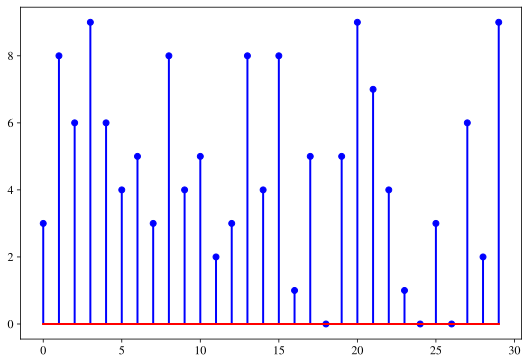

In [9]:
y = jax.nn.one_hot(y, 10)

a = []
for k in range(10):
    #
    #
    a_k = jnp.zeros(784)
    a.append(a_k)
a = jnp.array(a)

y_hat = jnp.argmax(jnp.matmul(X_val, a.T), axis=1)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

# Non-linear case
## Polynomial regression
What if the relation between $x$ and $y$ is not linear?

- Map $\phi: x \mapsto [x, x^2, x^3, \dots, x^p]$

$$ \min_\mathbf{a} \mathbb{E}_x[(y - \phi(x)^\top\mathbf{a})^2]$$

In [10]:
a = [-0.2, 0.7, 0.83, -1.5, 5.23]
p = np.poly1d(a)
x = np.random.rand(24)*4-2
y = p(x) + 0.2*np.random.randn(24)

[ 5.266477   -1.538329    0.6909166   0.7270644  -0.15955621]


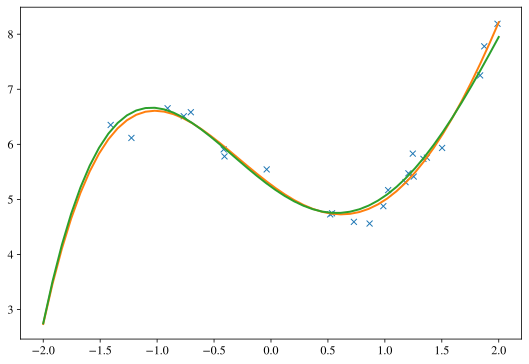

In [11]:
X = jnp.stack([jnp.ones((len(x))), x, x**2, x**3, x**4], axis=1)
U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)
print(a_hat)
pp = np.poly1d(a_hat[::-1])

t = np.linspace(-2, 2, 50)
plt.plot(x, y, 'x')
plt.plot(t, pp(t))
plt.plot(t, p(t))

## Periodic signals

Map $\phi: x \mapsto [\sin(f_0 x), \sin(2f_0x), \dots, \sin(pf_0x)]$

In [12]:
a = np.array([0.7, 0.83, -1.5])
x = np.random.rand(48)*16-8
X = jnp.array([ jnp.sin(x), jnp.sin(2*x), jnp.sin(3*x)])
y = jnp.matmul(a, X) + 0.3*np.random.randn(48)

In [13]:
X = jnp.array([jnp.sin(x), jnp.sin(2*x), jnp.sin(3*x)])
ap = jnp.matmul(jnp.matmul(jnp.linalg.inv(jnp.matmul(X, X.transpose())), X), y)
Yp = jnp.matmul(ap, X)

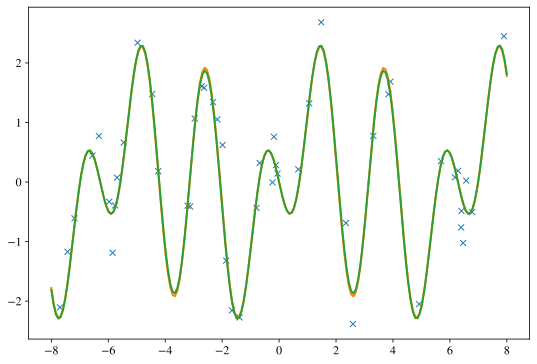

In [14]:
t = np.linspace(-8, 8, 200)
T = np.array([np.sin(t), np.sin(2*t), np.sin(3*t)])
plt.plot(x, y, 'x')
plt.plot(t, np.matmul(ap, T))
plt.plot(t, np.matmul(a, T))

## Overcomplete models

What if $p < \hat{p}$ (model has greater capacity than data)

Let use fit that curve with increasingly higher polynomial degrees.

In [15]:
def sin_approx(x, y, p):
    Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
    ap = jnp.matmul(jnp.matmul(jnp.linalg.inv(jnp.matmul(Xp, Xp.transpose())), Xp), y)
    Yp = jnp.matmul(ap, Xp)
    return ap, Xp, Yp

In [16]:
p = 3
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.66503567  0.8555399  -1.5098379 ]


MSE: 0.13037486374378204


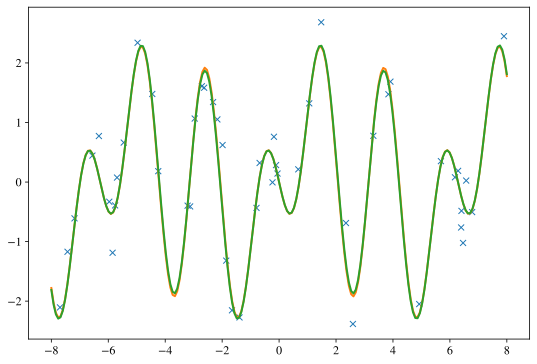

In [17]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [18]:
p = 5
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.66392684  0.8552013  -1.4939932  -0.07257754  0.05675733]


MSE: 0.1274968534708023


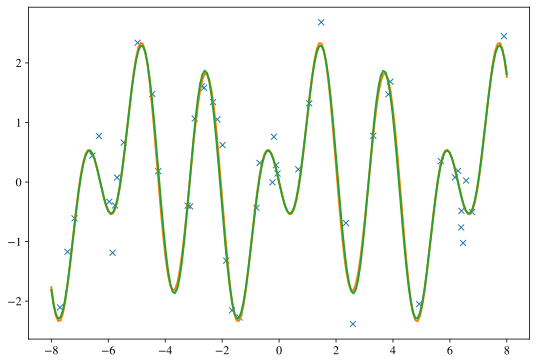

In [19]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [20]:
p = 10
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.64930737  0.86065483 -1.5159405  -0.0419542   0.10985056 -0.04247902
 -0.1989938   0.04065548  0.08720873 -0.07313146]


MSE: 0.1047743558883667


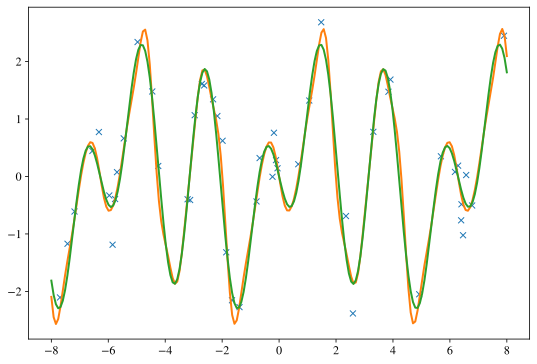

In [21]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [22]:
p = 15
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.64816654  0.85237145 -1.4848707  -0.06554112  0.17367777 -0.08139829
 -0.15539262  0.0064044   0.08781601 -0.0583418   0.01320645  0.03894603
 -0.13762946  0.01072791 -0.09005098]


MSE: 0.09392114728689194


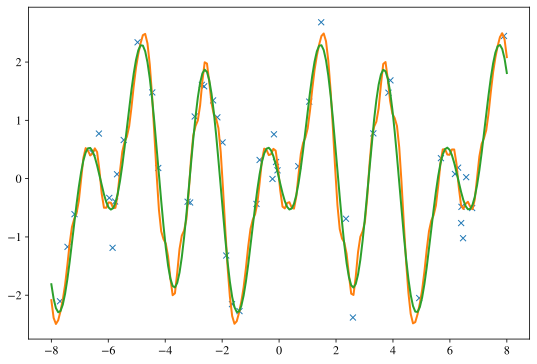

In [23]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [24]:
p = 20
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.63273454  0.862865   -1.5327747  -0.04082306  0.12400526 -0.07723609
 -0.18338399  0.05933774  0.09869707 -0.05381919  0.01258338  0.04874885
 -0.09009814 -0.00779995  0.00236045 -0.04848589 -0.05025677 -0.11085568
  0.04835366 -0.12392354]


MSE: 0.08044012635946274


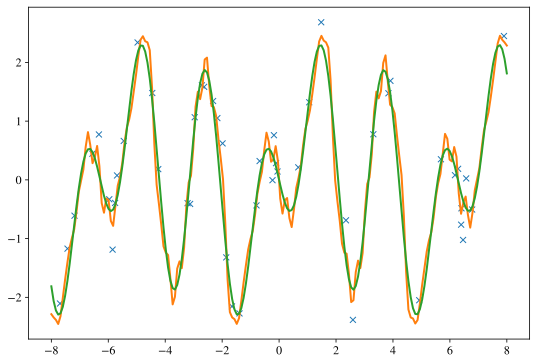

In [25]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [26]:
p = 25
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.5857791   0.9295168  -1.5959327  -0.06027614  0.15495446 -0.07315889
 -0.18192858 -0.00906502  0.12587665  0.02122447 -0.05915882  0.0195908
  0.00481635 -0.02463253 -0.0524892  -0.01131299 -0.07204011 -0.1264672
  0.09676984 -0.20841293  0.02010447  0.1596179  -0.20179838  0.03811657
  0.21566837]


MSE: 0.054160039871931076


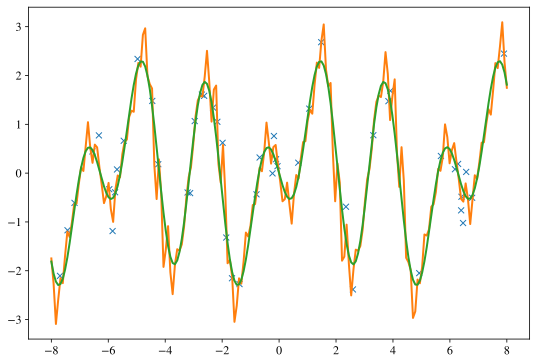

In [27]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [28]:
p = 35
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.60171056  2.1561666  -3.7234256   1.9323449  -1.881022    1.7465707
 -1.9733595   2.061804   -1.430026    0.31073868  0.800243   -1.7518697
  2.4190798  -2.4179287   1.7261914  -0.81368876  0.62834394 -1.0664698
  0.6718048  -0.6353989  -0.20793903  1.5484711  -1.6906972   0.984274
 -0.906407    0.850715   -0.3213622   0.83473617 -0.9671983   0.1878281
  0.6671101  -1.3488506   1.6334653  -0.616805   -0.2670184 ]


MSE: 0.02646658569574356


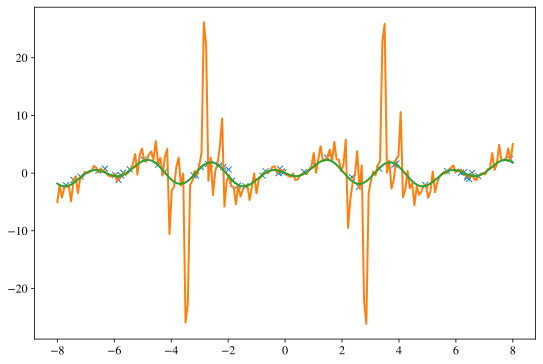

In [29]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

At some point, we are just fitting the noise. Remember that we can pass a polynomial exactly through all the training examples as soon as its degree is higher than the size of the training set. Because we are totally blind between the training examples, our function can take any value there and it will not be penalized by the loss. This is obvisouly a problem that can only be mitigated by making sure the function is also "observed" between the training examples. There are two ways of doing so.

## Train/validation

The first way is by performing validation. By having a set of example that is reserved for model selection, we measure the function outside of the training set and penalize functions that do not behave properly in that aspect. However, a validation set is finite and it still leaves blindspots.

In [30]:
x_val = np.random.rand(48)*16-8
X_val = jnp.array([ jnp.sin(x_val), jnp.sin(2*x_val), jnp.sin(3*x_val)])
y_val = jnp.matmul(a, X_val) + 0.3*np.random.randn(48)

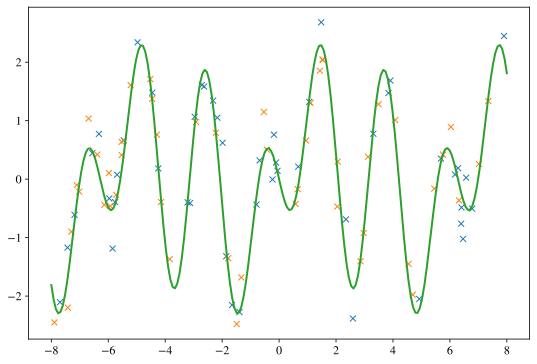

In [31]:
plt.plot(x, y, 'x')
plt.plot(x_val, y_val, 'x')
plt.plot(t, jnp.matmul(a, T[:len(a), :]))

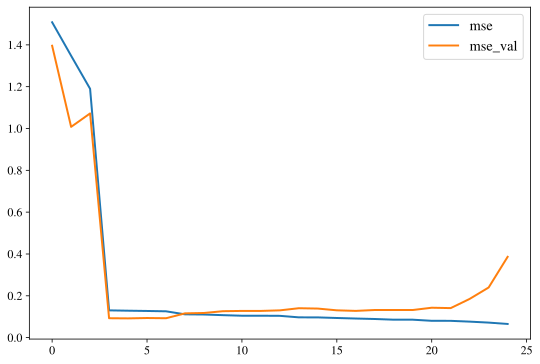

In [32]:
mse = []
mse_val = []
for p in range(25):
    ap, Xp, Yp = sin_approx(x, y, p)
    _, Xp_val, _ = sin_approx(x_val, y_val, p)
    Yp_val = jnp.matmul(ap, Xp_val)
    mse.append(((y - Yp)**2).mean()), mse_val.append(((y_val - Yp_val)**2).mean())
plt.plot(mse, label='mse'); plt.plot(mse_val, label='mse_val')
plt.legend()

# Regularization

The better way of handling blindspots in the loss is to somehow "observe" implicitly the function everywhere. This can be done by adding a structural cost that penalizes function that take values outside of the training samples that are radically different from the ones on the training examples. One easy way of doing so it to penalize functions that use all the parameters of their family, for example a high degree polynomial that has non-zero coefficient on all powers. Such function is the most complex of its family and should be attained only in rare cases where that capacity is required.

Noisy observation:
$$ y = \mathbf{a}^\top\mathbf{x} + \varepsilon, \varepsilon \sim \mathcal{N}(0, \sigma)$$

Assume $\|\mathbf{a}\|_0 < d$ (not all input dimensions are used), can we force $\hat{\mathbf{a}}$ to be also sparse?

$$ \min_\mathbf{a} \mathbb{E}_x[(y - \mathbf{x}^\top\mathbf{a})^2] + \Omega(\mathbf{a}) $$

With $\Omega(\mathbf{a})$ a *regularizer* that increases cost for more complex $\mathbf{a}$

## LASSO
Least Absolute Shrinkage and Selection Operator <cite data-cite="tibshirani1996regression">(Tibshirani, 1996)</cite>

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda\|\mathbf{a}\|_1 $$

Optimize using gradient descent

$$ \mathbf{a} \leftarrow \mathbf{a} - \eta \left[ \frac{-2}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a}) + \lambda\text{sign}(\mathbf{a}) \right] $$


The LASSO is interesting in that it is not exactly the cost that we would like (the better cost would be the $\ell_0$ norm that counts non zero components), but the one that has a similar behavior while being easier to optimize. There are countless specialized algorithms for optimizing the LASSO, but in practice and for large enough training sets, a gradient descent with a carefully chosen learning rate is good enough.

The main appeal for the LASSO is that enforcing a sparse model allows the practitioner to see which variables are in play. It has thus an explanatory value.

In [33]:
def sin_pred(a, X):
    return jnp.matmul(a, X)

def sin_lasso(a, X, y, lam):
    yp = sin_pred(a, X)
    return ((y - yp)**2).mean() + lam*jnp.abs(a).sum()

@jax.jit
def update(a, X, y, lam):
    da = jax.grad(sin_lasso, argnums=0)(a, X, y, lam)
    return a - 0.05*da

In [34]:
p=25
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
ap = jnp.zeros(p)
for i in range(100):
    ap = update(ap, Xp, y, 0.1)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 5.0244969e-01  6.7708075e-01 -1.3217005e+00 -5.5618468e-03
  2.1797190e-03 -2.4922101e-03 -7.4531697e-02 -6.1854455e-03
  1.1975669e-03 -3.2022649e-03 -3.3327036e-03  3.0571646e-03
 -1.7762976e-02 -5.9072860e-03 -4.4773789e-03 -6.0488996e-03
 -6.4997919e-02 -6.8982323e-03  1.4052609e-03 -7.1133333e-03
  3.2059646e-03 -7.8694215e-03 -4.8849126e-03  1.2485289e-02
  6.9161236e-02]


MSE: 0.06530888378620148


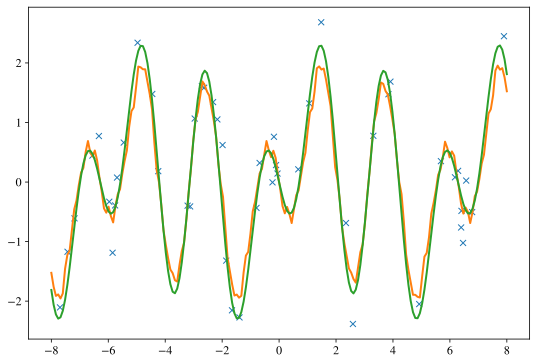

In [35]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

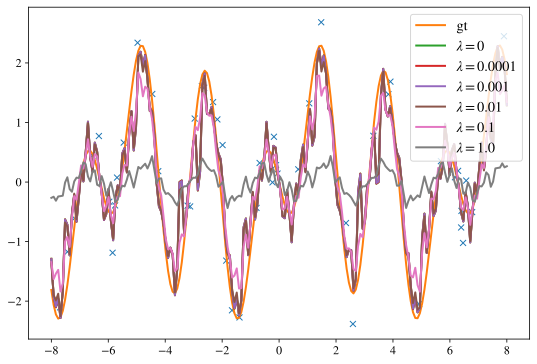

In [36]:
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(a, T[:len(a), :]), label='gt')
for lam in [0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    ap = jnp.zeros(p)
    for i in range(50):
        ap = update(ap, Xp, y, lam)
    plt.plot(t, jnp.matmul(ap, T[:len(ap), :]), label='$\lambda={}$'.format(lam))
plt.legend()

In [37]:
def lasso_approx(Xp, y, lam):
    ap = jnp.zeros(len(Xp[:,0]))
    for i in range(100):
        ap = update(ap, Xp, y, lam)
    Yp = jnp.matmul(ap, Xp)
    return ap, Xp, Yp 

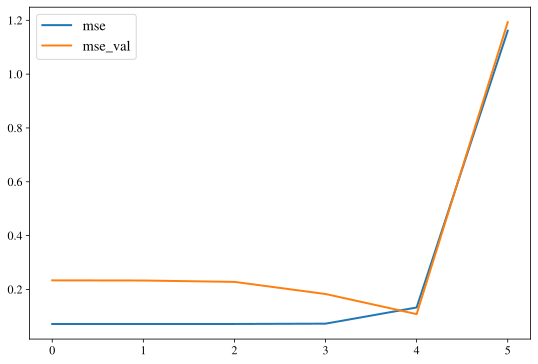

In [38]:
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
Xp_val = jnp.sin(jnp.matmul(x_val.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
mse = []
mse_val = []
for lam in [0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    ap, Xp, Yp = lasso_approx(Xp, y, lam)
    Yp_val = jnp.matmul(ap, Xp_val)
    mse.append(((y - Yp)**2).mean()), mse_val.append(((y_val - Yp_val)**2).mean())
plt.plot(mse, label='mse'); plt.plot(mse_val, label='mse_val')
plt.legend()

We exchanged one hyper-parameter (the degree) for another one ($\lambda$), and so we have no other choice but to use a validation set to select its value. However, we still gained something: we separated the idea of observing the function outside of the training set from selecting the better model. In the case of selecting the degree directly with the validation set, both where done on the same data, whereas with the regularization, we "observe" the function everywhere thanks to our regularizer without using any additional data and with select the correct hyper-parameter with the validation set.

## Analysis

Project $\mathbf{X}$ into its eigenspace:

$$ \min_\mathbf{a} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{Ua}\|^2 + \lambda\|\mathbf{a}\|_1 $$
$$ =  \frac{1}{n} \|\mathbf{y} - \mathbf{VSa}\|^2 + \lambda\|\mathbf{a}\|_1$$

Stationary condition: 

$$\frac{\partial}{\partial \mathbf{a}}  = 0 = -2\mathbf{SV}^\top\mathbf{y} + 2\mathbf{S}^2\mathbf{a} + \lambda\text{sign}(\mathbf{a})$$
$$\mathbf{a} = \mathbf{S}^{-1}\mathbf{V}^\top\mathbf{y} - \mathbf{S}^{-2}\frac{\lambda\text{sign}(\mathbf{a})}{2}$$

Let $\tilde{\mathbf{a}} = \mathbf{S}^{-1}\mathbf{V}^\top\mathbf{y}$

Note that $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = \frac{\tilde{\mathbf{a}}}{\vert\tilde{\mathbf{a}}\vert}$
$$\mathbf{a} = \tilde{\mathbf{a}}\left(1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}\vert}\right)$$

Case $>0$,  $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = 1$

$$ \mathbf{a}_i = \color{blue}{\underbrace{\tilde{\mathbf{a}}_i}_{>0}} \left(1 -  \frac{\lambda\mathbf{S}^{-2}_i}{2\vert\tilde{\mathbf{a}}_i\vert}\right) >0$$

$$ \mathbf{a}_i = \tilde{\mathbf{a}}_i \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}_i}{2\vert\tilde{\mathbf{a}}_i\vert}\right) $$

Case $<0$,  $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = -1$

$$ \mathbf{a}_i = \color{blue}{\underbrace{\tilde{\mathbf{a}}_i}_{<0}} \left(1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}_i\vert}\right) <0$$

$$ \mathbf{a}_i = \tilde{\mathbf{a}}_i \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}_i\vert}\right) $$

Soft thresholding: 

$$ \mathbf{a} = \tilde{\mathbf{a}} \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}\vert}\right) $$

$\lambda$ removes components that would change the sign of the solution $\rightarrow$ Sparse solution

*Remember: analysis only valid in eigenspace*

## Conditioning

In eigenspace, pseudo-inverse solution:
$$ \mathbf{a} = \mathbf{US}^{-1}\mathbf{V}^\top\mathbf{y}$$

What if $\mathbf{S}$ has small eigenvalues ($\text{span}(\mathbf{X}) < d$)?
How to prevent solution to focus on the noise?

Avoid large values in the solution:

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda\|\mathbf{a}\|^2 $$

Tikonov regularization (ridge regression)

Tikonov or $\ell_2$ regularization is the most popular regularization scheme. It shows up everywhere. The intuition is very simple: you do not want some parameters of the model to blow up because of the optimization, so you penalize large values. Simple, but effective.

## Analysis

$$\frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a}\|^2 + \lambda\|\mathbf{a}\|^2 $$


Stationary condition: 

$$\frac{\partial}{\partial \mathbf{a}} = 0 =\frac{2}{n}(-\mathbf{X}^\top\mathbf{y} + \mathbf{XX}^\top\mathbf{a}) +2\lambda\mathbf{a} $$

$$\mathbf{a} = (\mathbf{XX}^\top +n\lambda\mathbf{I})^{-1}\mathbf{X}^\top\mathbf{y} $$

Offsetting all eigenvalues in the covariance matrix by $\lambda$

Adding entries on the diagonal on the covariance matrix (hence the name _ridge_) has two effect: First, it makes sure the entire space is spanned by the data making the inversion possible. Second, it compresses the importance of the larger dimensions, making the orginal data look more and more like a sphere. A similar effect could be obtained by a whitened PCA (reduce dimension and standardize to have variance 1 everywhere).

## Elastic net

Add both regularization

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda_1\|\mathbf{a}\|_1 +\lambda_2\|\mathbf{a}\|_2^2$$

- $\lambda_1$ controls sparsity
- $\lambda_2$ controls sensitivity to noisy components

Optimize using gradient descent


You may want to do both because they have complementary properties. $\ell_1$ produces a sparse solution that is explanatory, $\ell_2$ prevents some parameters to blow up.

# Other loss functions

$\ell_2$ is sensitive to outliers

0.8166666


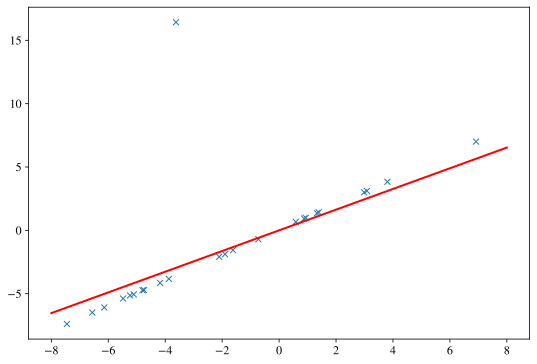

In [39]:
x = np.random.rand(24)*16-8
y = x + 0.1*np.random.rand(24)
y[0] += 20

a = jnp.dot(x, y)/jnp.dot(x, x)
print(a)
t = jnp.linspace(-8, 8, 10)
plt.plot(x, y, 'x')
plt.plot(t, a*t, '-r')

## MAE

Mean absolute error (or $\ell_1$ error)

$$\min_\mathbf{a} \mathbb{E}[ \vert y_i - \mathbf{a}^\top\mathbf{x}_i\vert ]$$

Vector case 

$$\min_\mathbf{a} \mathbb{E}[ \| \mathbf{y}_i - \mathbf{A}^\top\mathbf{x}_i\|_1 ]$$

No close form solution, gradient descent (subderivative $\nabla\|0\|_1 = 0$)

*robust* regression

1.0179636


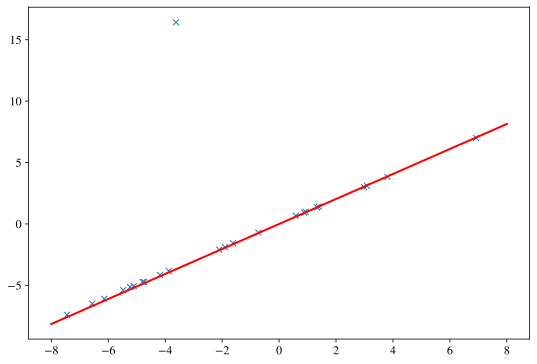

In [40]:
def l1(a, x, y):
    return jnp.abs(y - a*x).mean()

@jax.jit
def update(a, x, y):
    da = jax.grad(l1, argnums=0)(a, x, y)
    return a - 0.02*da

a = 0.
for i in range(100):
    a = update(a, x, y)
print(a)
t = jnp.linspace(-8, 8, 10)
plt.plot(x, y, 'x')
plt.plot(t, a*t, '-r')

Robust regression is important for tasks where details matter. For example, in everything image related, using $\ell_2$ leads to blury images because small errors are not takens into account enough, whereas $\ell_1$ usually produces sharper results.

# Sensitivity to small errors
- $\ell_2$: derivative falls quickly to zero
- $\ell_1$: constant derivative

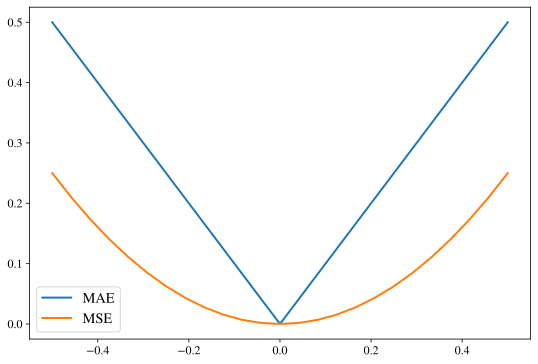

In [41]:
t = jnp.linspace(-0.5, 0.5, 25)
plt.plot(t, jnp.abs(t), label='MAE')
plt.plot(t, t**2, label='MSE')
plt.legend()

The caveat is that although $\ell_2$ can be longer to optimize because of the smaller and smaller gradient, $\ell_1$ can be trickier because of jittering (when the solution oscillates between different sides of the optimal point).

## Do both?

- Penalize large errors: $\ell_2$
- Penalize small errors (assuming no outliers): $\ell_1$

$$ \min_\mathbf{A} \mathbb{E}[ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 + \lambda \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|_1 ]$$

Optimize using gradient descent

## Full model
- Ridge regularization (noisy components)
- Sparsity regularization (overcomplete model)
- Large errors penalization
- Small errors penalization 

$$ \min_\mathbf{A} \mathbb{E}[ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 + \lambda \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|_1 ] + \lambda_2 \|\mathbf{A}\|_F^2 + \lambda_1 \|\mathbf{A}\|_1$$

- Optimize using gradient descent (surprise!)
- 3 hyper-parameters: use proper cross validation ("*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk*", J. Von Neumann)

Using proper cross-validation is essential. People tend to vastly under-estimate the potential for overfitting with only 3 hyper-parameters. Here, all of them have a global impact on the solution, they are more potent in their effect than adding one to the degree of the polynomial.

# Dictionary learning

Unsupervised learning: target space is a new representation of the input space

- Input: $\mathbf{X} \in \mathbb{R}^{d\times n}$
- Model: Dictionary $\mathbf{D} \in \mathbb{D}^{d\times p}$
- Output: Factors $\mathbf{A} \in \mathbb{R}^{p\times n}$

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2 $$

If $p < d$, then $\mathbf{D}$ are the $p$ leading left singular vectors of $\mathbf{X}$ and the factors $\mathbf{A}$ are the combination of the corresponding singular values with the right singular vectors

If $p > d$, we have an *overcomplete* dictionary, which means we can afford to not use all entries to reconstruct a sample

$$ \min_{\mathbf{a}} \|\mathbf{x} - \mathbf{Da}\|^2 +\lambda \|\mathbf{a}\|_0$$
Sparse coding





Alternate update:

- Fix $\mathbf{D}$, update $\mathbf{A}$

  - Difficult problem, relax to $\|\mathbf{a}\|_1$ or use iterative thresholding methods
  
- Fix $\mathbf{A}$, update $\mathbf{D}$

$$\mathbf{D} = \mathbf{X}(\mathbf{A}^\top\mathbf{A})^{-1}$$

## K-SVD

Update one atom at a time (see <cite data-cite="aharon2006ksvd">(Aharon et al, 2006)</cite>)

- $\mathbf{d}_k$: atom $k$ of the dictionary
- $\mathbf{a}^k \in \mathbb{R}^n$: factors corresponding to atom $k$ 
- $\bar{\mathbf{D}}_k = [\mathbf{d}_i]_{i\neq k} \in \mathbb{R}^{d\times p-1}$: reduced dictionary without atom $\mathbf{d}_k$
- $\bar{\mathbf{A}}^k = [\mathbf{a}_i]_{i\neq k} \in \mathbb{R}^{p-1\times n}$: factors corresponding to the reduced dictionary

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2 = \|\mathbf{X} - \bar{\mathbf{D}}_k\bar{\mathbf{A}}^k - \mathbf{d}_k\mathbf{a}^k\|_F^2$$

$$ \mathbf{E}_k = \mathbf{X} - \bar{\mathbf{D}}_k\bar{\mathbf{A}}^k$$

Iterative updates: 
$$\min_{\mathbf{d}_k, \mathbf{a}^k} \|\mathbf{E}_k - \mathbf{d}_k\mathbf{a}^k\|_F^2$$

- SVD of $\mathbf{E}_k = \mathbf{USV}^\top$
- Rank 1 approximation: $\mathbf{E}_k \approx \mathbf{u}_1s_1\mathbf{v}_1^\top$
- Get hard thresholding selection matrix: $\Omega_k \in \{0, 1\}^{n\times n'}$, that select $n'$ samples that are coded by atom $k$ (ex: highest absolute values of $\mathbf{v}_1$)
- Compute reduced problem for selected samples:
$$\min_{\mathbf{d}_k, \mathbf{a}^k} \|\mathbf{E}\Omega_k - \mathbf{d}_k\mathbf{a}^k\Omega_k\|_F^2$$
- Update $\mathbf{d}_k$ and $\mathbf{a}^k$ using rank-1 approximation of $\mathbf{E}_k\Omega_k \approx \mathbf{u}s\mathbf{v}^\top$

In [42]:
X = jnp.transpose(data['X_train'])
y = data['y_train']

D = np.random.rand(784, 64)
A = np.random.rand(64, 100)

for e in range(50):
    D = jnp.matmul(jnp.matmul(X, A.T), jnp.linalg.inv(jnp.matmul(A, A.T)))
    A = jnp.matmul(jnp.linalg.inv(jnp.matmul(D.T, D)), jnp.matmul(D.T, X))
    S = jnp.sign(A)
    I = jnp.argsort(jnp.abs(A), axis=0)[-33, :]
    A = S * jnp.clip(jnp.abs(A) - jnp.abs(A[I, jnp.arange(100)]), a_min=0)

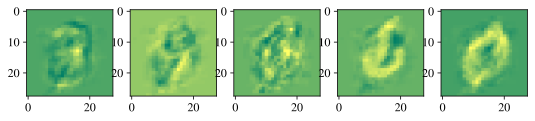

In [43]:
plt.subplot(1,5,1)
plt.imshow(D[:,0].reshape(28, 28))
plt.subplot(1,5,2)
plt.imshow(D[:,1].reshape(28, 28))
plt.subplot(1,5,3)
plt.imshow(D[:,2].reshape(28, 28))
plt.subplot(1,5,4)
plt.imshow(D[:,3].reshape(28, 28))
plt.subplot(1,5,5)
plt.imshow(D[:,4].reshape(28, 28))

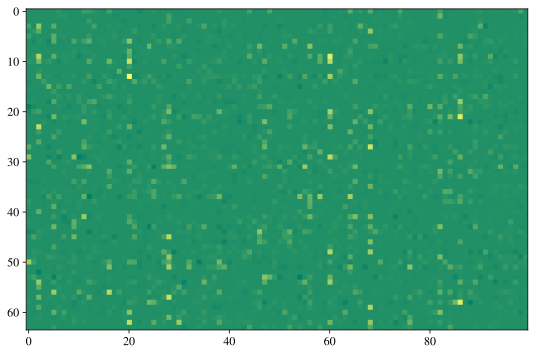

In [44]:
plt.imshow(A)

## MNIST

Exercise: Try a linear regression (vector output) using $\mathbf{A}$ instead of $\mathbf{X}$

## Why?

- $\mathbf{A}$ may provide a better alternative to $\mathbf{X}$ for doing learning a predictor
- $\mathbf{D}$ may provide insights (modes of $\mathbf{X}$)

Dictionary learning was once a very hot topic because usually the original data is not in a good format to perform linear prediction on it. It is a way of obtaining a better representation, without requiring labels. It has since been mostly replaced by deep representation learning (especially self-supervised learning) but may make a comeback in very specific cases.

Relation to k-means

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2\quad \text{ s.t.   } \forall i, \|\mathbf{a}_i\|_0 = 1$$
- Only a single atom selected per sample
- Alternate optimization:

$$\mathbf{d}_k = \frac{\mathbf{X}\mathbf{a}^{k\top}}{\|\mathbf{a}^k\|_1}$$
$$\mathbf{a}_i = [\mathbf{1}_{m=n}]_m, n = \text{argmin}_k\|\mathbf{d}_k - \mathbf{x}_i\|$$


# Linear Model (regression), take home

- MSE often leads to closed form solution
- MSE to penalize large errors, MAE to penalize small errors
- MAE robust to outliers

- Sensitivity to condition number: $\ell_2$ regularization
- Sparse model: $\ell_1$ regularization

- Dictionary learning

  - Find better representation with a linear model


- Non linear relation: explicit non-linear mapping + linear model